In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments_jax import *
from instruments import *
from physical_models import *
from scipy import stats as scipy_stats
import h5py
import corner
import shutil

In [2]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin zero here, but I would recommend using a bin more in the middle to get a good idea,
# bin zero can be finicky
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')

# Read in data
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath, mode='physical_model_CHARIS')
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  144
[-5.22213279e-01  4.02450338e+08 -3.91877275e-01  4.00912593e+08
 -2.46134292e-02  3.98605969e+08  3.77378452e-01  3.98571117e+08
  5.86235703e-01  4.00370202e+08]
Interleaved Stds
Length:  144
[4.25107378e-05 2.00611649e+04 4.59484896e-05 2.00228018e+04
 5.00721811e-05 1.99651188e+04 4.63858804e-05 1.99642460e+04
 4.04882954e-05 2.00092529e+04]
Configuration List
Length:  72
[{'hwp': {'theta': 0.0, 'wavelength_bin': 15}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 15}}, {'hwp': {'theta': 11.25, 'wavelength_bin': 15}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 15}}, {'hwp': {'theta': 22.5, 'wavelength_bin': 15}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 15}}, {'hwp': {'theta': 33.75, 'wavelength_bin': 15}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 15}}, {'hwp': {'theta': 45.0, 'wavelength_bin': 15}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 15}}, {'hwp': {'theta': 56.25, 'wavelength_bin': 15}, 'image_rotator': {'

In [3]:
def read_csv_physical_model_all_bins(csv_dir):
    """Does the same thing as read_csv() but reads all 22 csvs written
    in a directory for all 22 CHARIS wavelength bins and puts everything into one array.
    Also adds wavelength bin to the configuration dictionary for use with custom
    pyMuellerMat common mm functions. 
    Parameters:
    -----------
    csv_dir : Path or str
        The directory where the csv files are stored. Will check for bins in the title
        and for 22 files.

    Returns:
    -----------
    interleaved_values_all : list
        A list of interleaved values for all wavelength bins.
    interleaved_stds_all : list
        A list of interleaved standard deviations for all interleaved values.
    configuration_list_all : list
        A list of configuration dictionaries.
    """
    # Check if the directory exists
    csv_dir = Path(csv_dir)
    if not csv_dir.is_dir():
        raise FileNotFoundError(f"The directory {csv_dir} does not exist.")
        # Load csvs

    csv_files = sorted(csv_dir.glob("*.csv"))

    # Check for bins and sort files
 
    for f in csv_files:
     try:
        match = re.search(r'bin(\d+)', f.name)
        if not match:
            raise ValueError(f"File {f.name} does not contain the bin number.")
     except Exception as e:
        raise ValueError(f"Error processing file {f.name}: {e}")
    sorted_files = sorted(csv_files, key=lambda f: int(re.search(r'bin(\d+)', f.name).group(1)))
    if len(sorted_files) != 22:
        raise ValueError("Expected 22 CSV files for all wavelength bins, but found {}".format(len(sorted_files)))
    
    interleaved_values_all = []
    interleaved_stds_all = []
    configuration_list_all = []
    for file in sorted_files:
        interleaved_values, interleaved_stds, configuration_list= read_csv(file, mode='physical_model_CHARIS')
        interleaved_values_all = np.append(interleaved_values_all, interleaved_values)
        interleaved_stds_all = np.append(interleaved_stds_all, interleaved_stds)
        configuration_list_all.extend(configuration_list)

    return interleaved_values_all, interleaved_stds_all, configuration_list_all


    

In [4]:
# test new read func
csv_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff')
interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csv_dir)



In [5]:
# debug read
interleaved_valuess = interleaved_values[:143]
interleaved_stdss = interleaved_stds[:143]
configuration_listt = configuration_list_all[:71]
print(configuration_listt)

[{'hwp': {'theta': 0.0, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 11.25, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 22.5, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 33.75, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 45.0, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 56.25, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 67.5, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 78.75, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 90.0, 'wavelength_bin': 0}, 'image_rotator': {'theta': 45.0, 'wavelength_bin': 0}}, {'hwp': {'theta': 0.0, 'wavelength_bin': 0}, 'image_rotator': {'theta': 57.5, 

In [6]:
# Try mcmc
wavelength_bin = 15 # placeholder

epsilon_cal = 1 # perfect for now
offset_imr = -0.01062 # derotator offset
offset_hwp = -0.0022 # HWP offset
offset_cal = -0.0315 # calibration polarizer offset
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits
d = 259.7 
wsio2 = 1.617
wmgf2 = 1.264
# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength_bin":wavelength_bin, "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "SCExAO_HWP_function",
        "properties" : {"wavelength_bin": wavelength_bin, "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal, "delta_theta": offset_cal },
        "tag": "internal",
    }}
}
    

p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": offset_imr},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": offset_hwp},
    "lp" : 
        {"delta_theta": offset_cal},
}

system_mm = generate_system_mueller_matrix(system_dict)

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021 

d_bounds = (0.8*p0[2], 1.2*p0[2])
imr_offset_bounds = (0.8*offset_imr, 1.2*offset_imr)
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
hwp_offset_bounds = (0.8*offset_hwp, 1.2*offset_hwp)
cal_offset_bounds = (0.8*offset_cal, 1.2*offset_cal)

bounds = {
    "image_rotator" : 
        {"d": d_bounds, "delta_theta": imr_offset_bounds},
    "hwp" :  
        {"w_SiO2": wsio2_bounds, "w_MgF2": wmgf2_bounds, "delta_theta": hwp_offset_bounds},
    "lp" : 
        {"delta_theta": cal_offset_bounds},
}

# Define our gaussian priors
offset_prior = partial(mcmc.uniform_prior, low=-0.5, high=0.5)
d_prior = partial(mcmc.uniform_prior, low=0.7*p0[2], high=1.3 * p0[2])
imr_offset_prior = offset_prior
wsio2_prior = partial(mcmc.uniform_prior, low=0.7*p0[0], high=1.3 * p0[0])
wmgf2_prior = partial(mcmc.uniform_prior, low=0.7*p0[1], high=1.3 * p0[1])
hwp_offset_prior = offset_prior
cal_offset_prior = offset_prior


priors = {
    "image_rotator": {
        "d": d_prior,
        "delta_theta": imr_offset_prior,
    },
    "hwp": {
        "w_SiO2": wsio2_prior,
        "w_MgF2": wmgf2_prior,
        "delta_theta": hwp_offset_prior,
    },
    "lp": {
        "delta_theta": cal_offset_prior,
    }
}

  

output_h5 = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/mcmc_output.h5')

#write p0 dict to json
import json
with open('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/mcmc_p0_dict.json', 'w') as f:
    json.dump(p0_dict, f)
json_filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/mcmc_p0_dict.json')

In [7]:
def run_mcmc(
    p0_dict, system_mm, dataset, errors, configuration_list,
    priors, bounds, logl_function, output_h5_file,
    nwalkers=64, nsteps=10000, pool_processes=None, 
    s_in=np.array([1, 0, 0, 0]), process_dataset=None, 
    process_errors=None, process_model=None, resume=True,
    include_log_f=False, log_f=-3.0
):
    """
    Run MCMC using emcee with support for dictionary-based parameter inputs.

    This function supports standard system Mueller matrix fitting as well as
    extended likelihoods that include a noise-scaling term (`log_f`) in the model.

    Parameters
    ----------
    p0_dict : dict
        Nested dictionary of initial parameter guesses structured by component.
    system_mm : SystemMuellerMatrix
        The optical system's Mueller matrix object.
    dataset : np.ndarray
        Observed data values (interleaved double differences and sums).
    errors : np.ndarray
        Standard deviations associated with each element of `dataset`.
    configuration_list : list of dict
        List of per-measurement configurations (e.g., HWP/FLC angles).
    priors : dict
        Dictionary mapping parameter names to prior functions.
    bounds : dict
        Dictionary of (low, high) tuples for each parameter.
    logl_function : callable
        Log-likelihood function to evaluate model fit.
    output_h5_file : str
        Path to the output HDF5 file used to store MCMC results.
    nwalkers : int, optional
        Number of walkers (default is max of 2x parameters or process-scaled).
    nsteps : int, optional
        Number of steps for each walker.
    pool_processes : int, optional
        Number of parallel processes to use.
    s_in : np.ndarray, optional
        Input Stokes vector for the system (default: [1, 0, 0, 0]).
    process_dataset : callable, optional
        Function to process the dataset before likelihood comparison.
    process_errors : callable, optional
        Function to process errors in the same way as the dataset.
    process_model : callable, optional
        Function to process model outputs before likelihood comparison.
    resume : bool, optional
        If True and the HDF5 file exists, resume from saved state.
    include_log_f : bool, optional
        If True, appends a `log_f` noise inflation parameter to the parameter list.
    log_f0 : float, optional
        Initial value for `log_f` if `include_log_f` is True.

    Returns
    -------
    sampler : emcee.EnsembleSampler
        The sampler object containing the MCMC chain.
    p_keys : list of tuple
        List of (component, parameter) key pairs used for tracking parameters.
    """


    p0_values, p_keys = parse_configuration(p0_dict)

    if include_log_f:
        p0_values = p0_values + [log_f]             

    ndim = len(p0_values)

    resume = os.path.exists(output_h5_file)
    backend = emcee.backends.HDFBackend(output_h5_file)

    if not resume or backend.iteration == 0:
        backend.reset(nwalkers, ndim)

    pos = p0_values + 1e-3 * np.random.randn(nwalkers, ndim)

    args = (
        system_mm, dataset, errors, configuration_list, p_keys, s_in,
        process_model, process_dataset, process_errors,
        priors, bounds, logl_with_logf
    )

    with Pool(processes=pool_processes) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc.log_prob, 
            args=args, pool=pool, backend=backend)
        sampler.run_mcmc(pos, nsteps, progress=True)

    return sampler, p_keys


In [8]:
# Auto-detect computing resources
ndim = 6  # Number of parameters to fit
pool_processes = max(1, os.cpu_count() - 1) # Leaving one free
nwalkers = max(2 * ndim, pool_processes * 2)
if nwalkers % pool_processes != 0:
    nwalkers += pool_processes - (nwalkers % pool_processes)

print(f"Auto-detected: {pool_processes} processes, {nwalkers} walkers for {ndim} parameters")
sampler, p_keys = run_mcmc(p0_dict, system_mm, interleaved_values_all, interleaved_stds_all,configuration_list_all,priors,bounds,logl_with_logf, output_h5,nwalkers=14, include_log_f=True, log_f=-3.0, pool_processes=pool_processes)

Auto-detected: 7 processes, 14 walkers for 6 parameters


You must install the tqdm library to use progress indicators with emcee
/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/.conda/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


In [10]:
def plot_corner_flat(chain, param_names, step_range=(0, None), median_or_max="median", num_bins=100):
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])
    converted_chain = flat_chain.copy()

    for i, name in enumerate(param_names):
        if ".phi" in name:
            converted_chain[:, i] = converted_chain[:, i] / (2 * np.pi)

    if median_or_max == "median":
        truths = np.median(converted_chain, axis=0)
    elif median_or_max == "max":
        truths = []
        for i in range(converted_chain.shape[1]):
            hist, bin_edges = np.histogram(converted_chain[:, i], bins=num_bins)
            max_index = np.argmax(hist)
            max_val = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2
            truths.append(max_val)
        truths = np.array(truths)
    else:
        raise ValueError("median_or_max must be 'median' or 'max'")

    fig = corner.corner(
        converted_chain,
        labels=[label.replace(".phi", ".phi") for label in param_names],
        truths=truths,
        plot_datapoints=False,     # disables individual scatter points
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.xaxis.labelpad = 40
        ax.yaxis.labelpad = 40

    plt.tick_params(axis='x', which='both', pad=5)
    plt.tick_params(axis='y', which='both', pad=5)
    plt.show()

def load_chain_and_labels(h5_filename, txt_filename, include_logf=False):
    base, ext = os.path.splitext(h5_filename)
    h5_copy = base + "_copy" + ext
    shutil.copy(h5_filename, h5_copy)

    with h5py.File(h5_copy, 'r') as f:
        chain = f['mcmc']['chain'][:]

    with open(txt_filename, 'r') as f:
        p0_dict = json.load(f)

    param_names = [f"{comp}.{param}" for comp, params in p0_dict.items() for param in params]
    if include_logf:
        param_names.append("log_f")

    return chain, param_names

In [ ]:
f=''

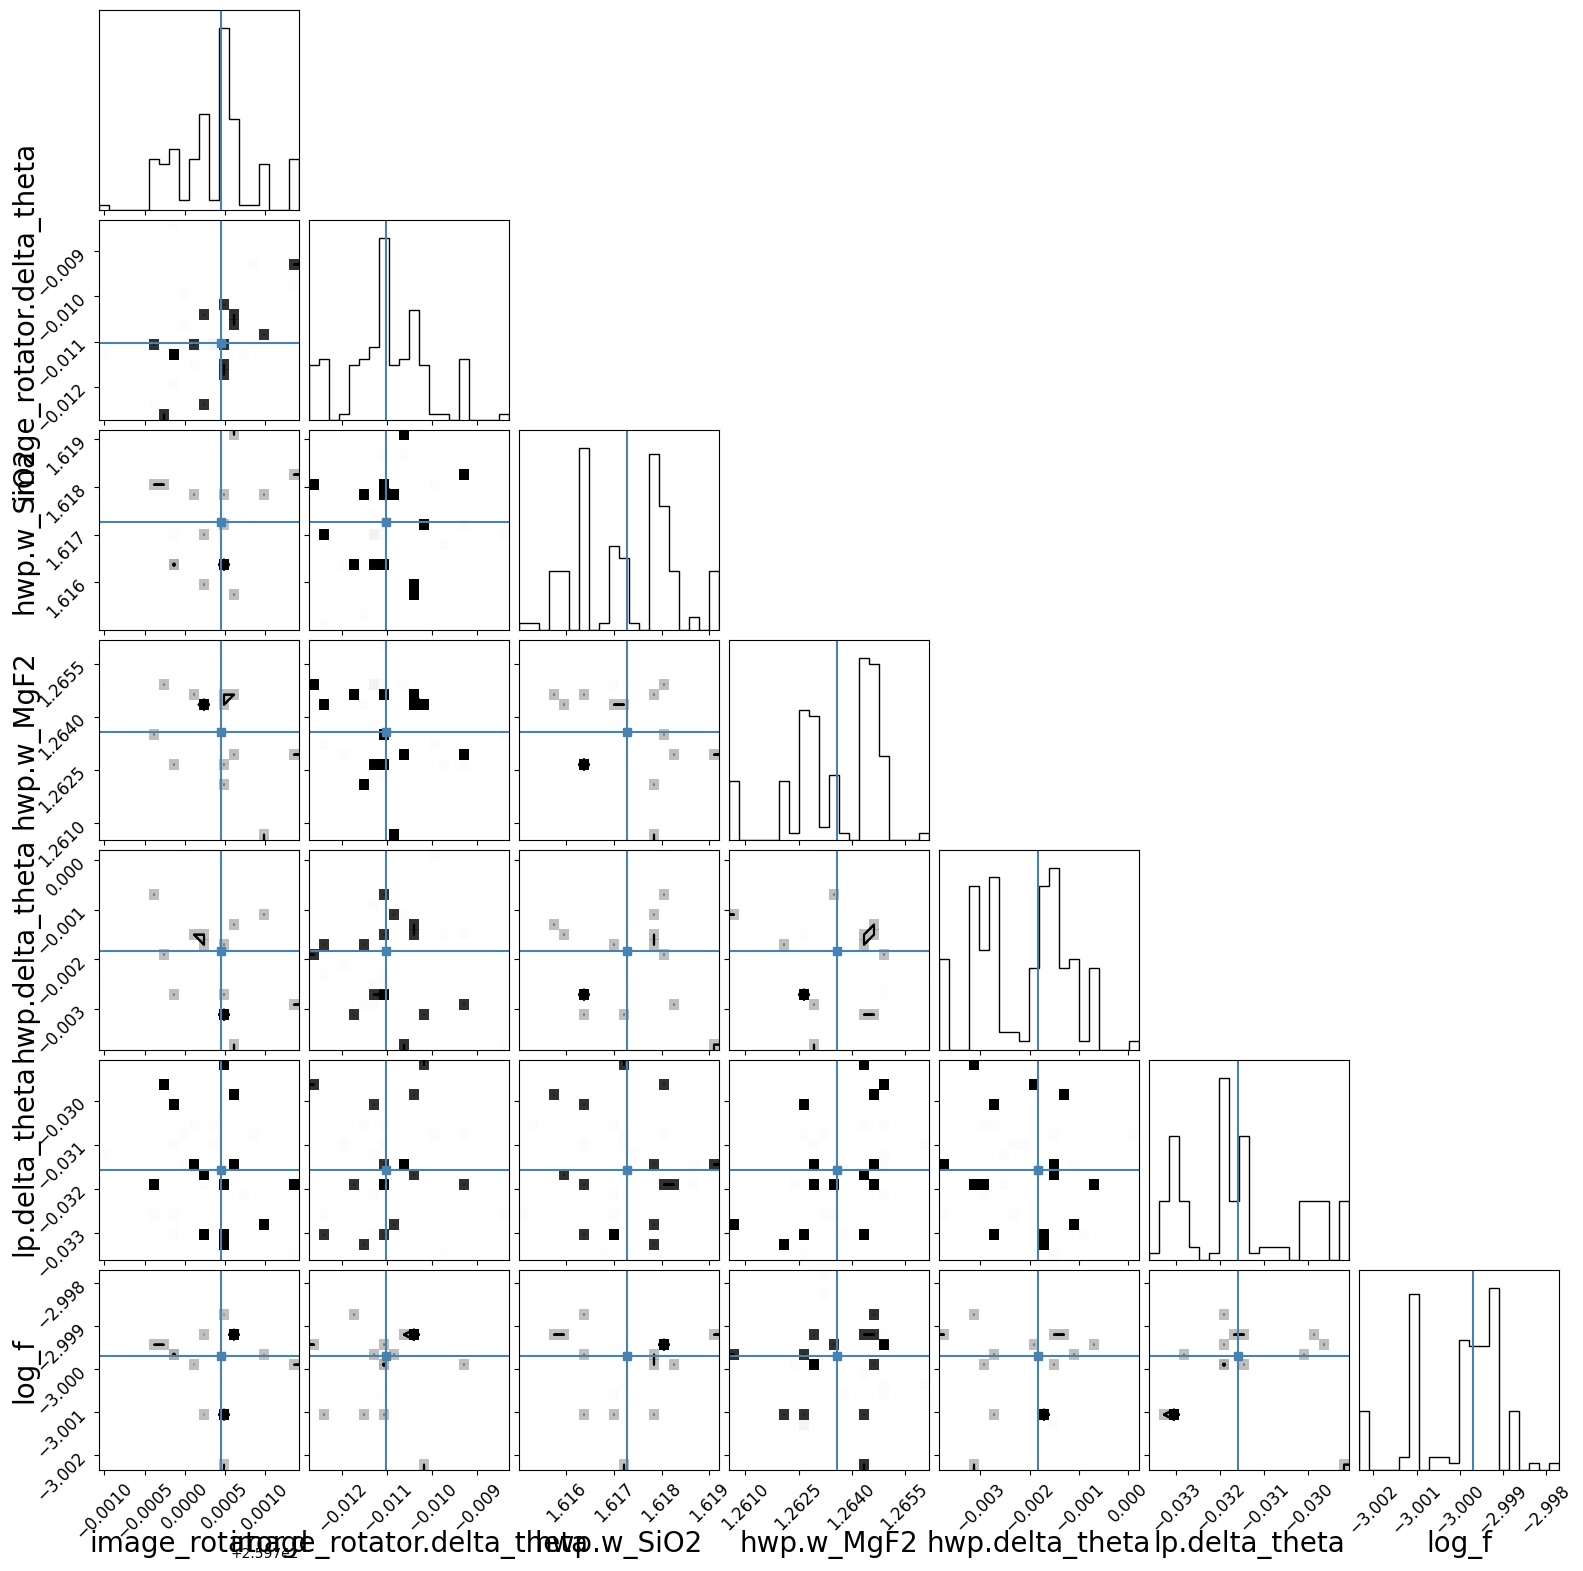

(21084, 14, 7)


In [11]:
chain, names = load_chain_and_labels(output_h5, json_filepath, include_logf = True)
corner_plot_step_range = (0,11084)
plot_corner_flat(chain, names, step_range=corner_plot_step_range)
print(chain.shape)


Shape: (21084, 14, 7)
NaNs: False
Infs: False
Means: [ 2.59700317e+02 -1.06110587e-02  1.61708006e+00  1.26372372e+00
 -2.10631873e-03 -3.17914159e-02]
Stds : [0.00074093 0.00112904 0.00106877 0.00127909 0.00106395 0.00130748]


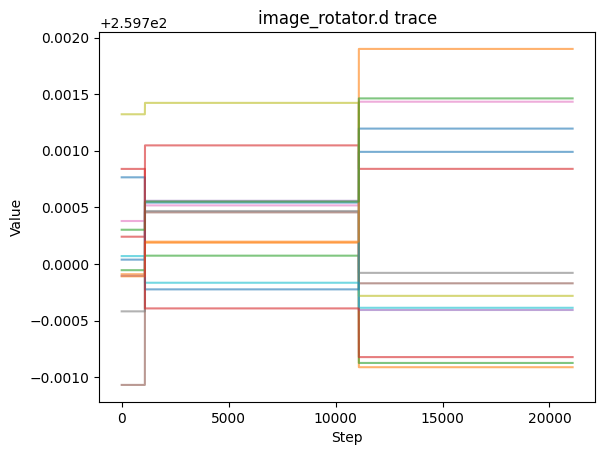

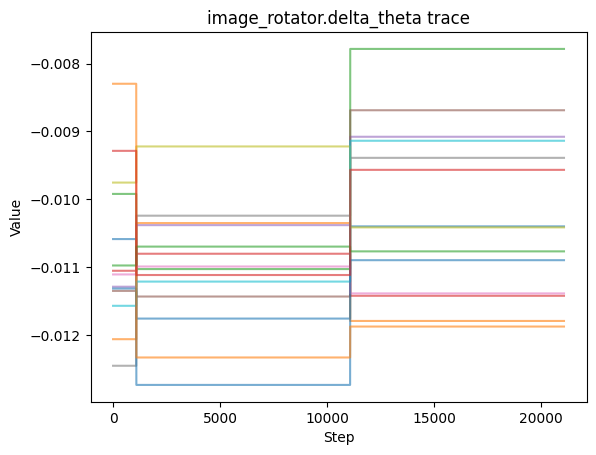

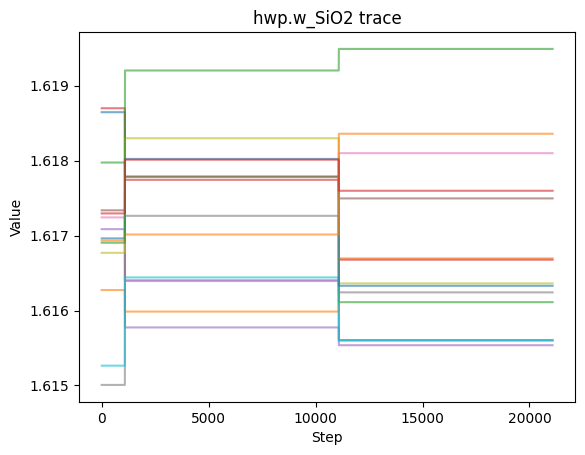

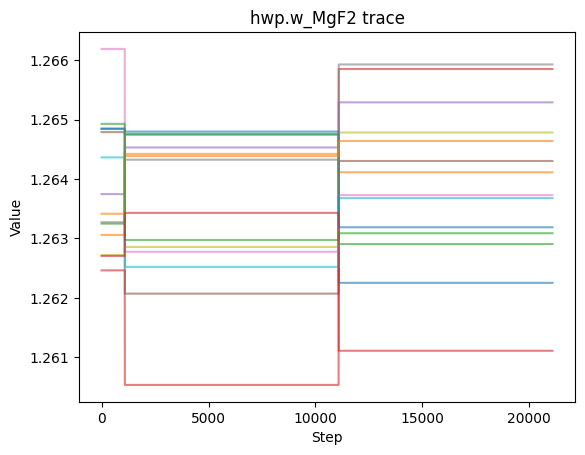

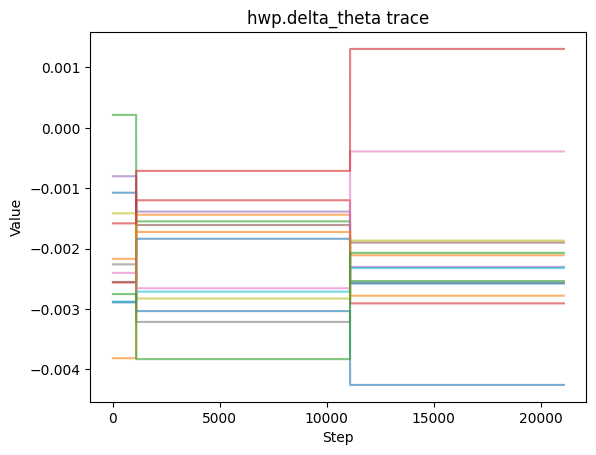

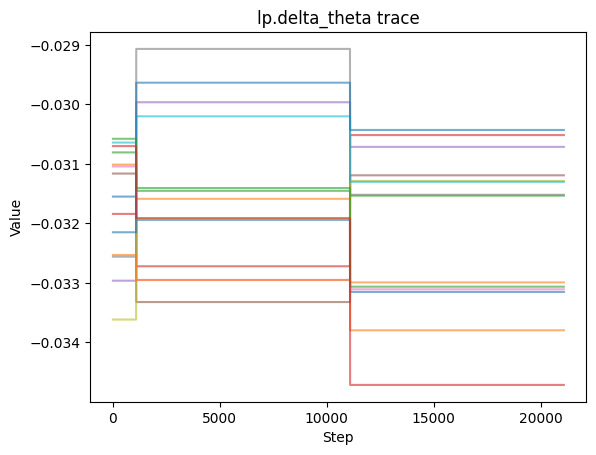

In [12]:
print("Shape:", chain.shape)
print("NaNs:", np.isnan(chain).any())
print("Infs:", np.isinf(chain).any())

means = np.mean(chain[:, :, :-1], axis=(0, 1))
stds = np.std(chain[:, :, :-1], axis=(0, 1))
print("Means:", means)
print("Stds :", stds)
for i in range(6):  # skip log(f)
    plt.figure()
    for w in range(14):
        plt.plot(chain[:, w, i], alpha=0.6)
    plt.title(f"{names[i]} trace")
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

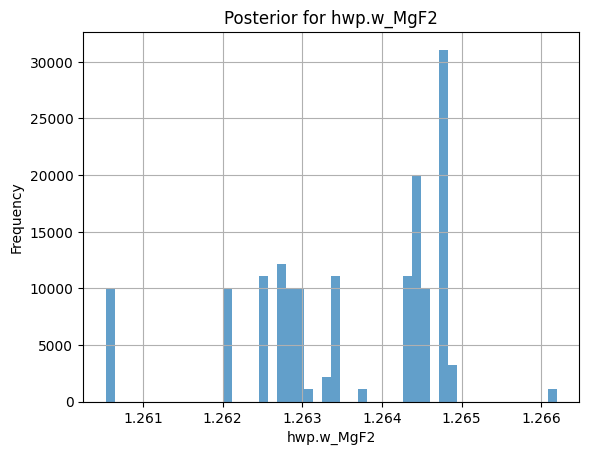

In [43]:
flat_chain = chain[:, :, :-1].reshape(-1, 6)
import matplotlib.pyplot as plt

param_index = 3  # or whichever parameter you want
plt.hist(flat_chain[:, param_index], bins=50, alpha=0.7)
plt.xlabel(names[param_index])  # if you loaded parameter names
plt.ylabel("Frequency")
plt.title(f"Posterior for {names[param_index]}")
plt.grid(True)
plt.show()

In [ ]:
# Auto-detect computing resources
ndim = 6  # Number of parameters to fit
pool_processes = max(1, os.cpu_count() - 1) # Leaving one free
nwalkers = max(2 * ndim, pool_processes * 2)
if nwalkers % pool_processes != 0:
    nwalkers += pool_processes - (nwalkers % pool_processes)

print(f"Auto-detected: {pool_processes} processes, {nwalkers} walkers for {ndim} parameters")
sampler, p_keys = run_mcmc(p0_dict, system_mm, interleaved_values_all, interleaved_stds_all,configuration_list_all,priors,bounds,logl_with_logf, output_h5,nwalkers=14, include_log_f=True, log_f=-3.0, pool_processes=pool_processes)

Auto-detected: 7 processes, 14 walkers for 6 parameters


You must install the tqdm library to use progress indicators with emcee
